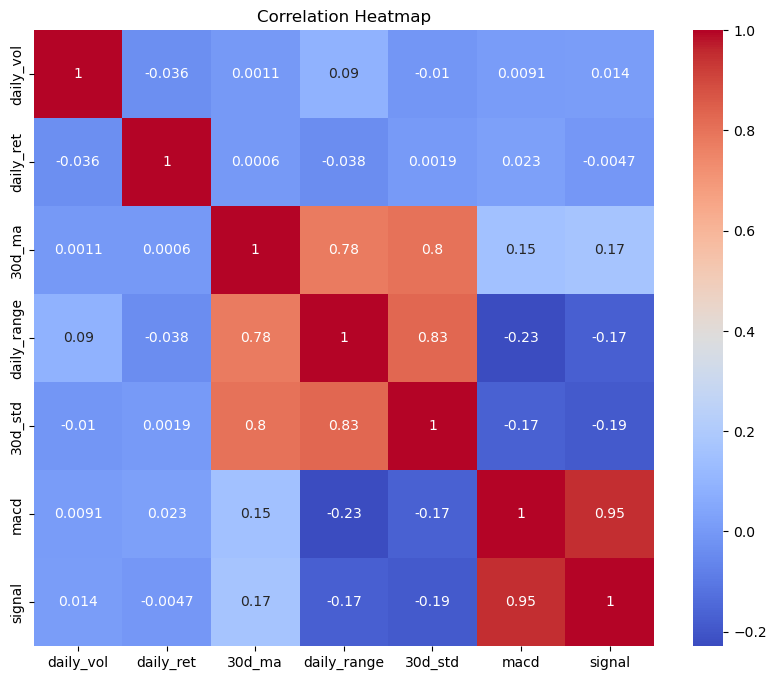

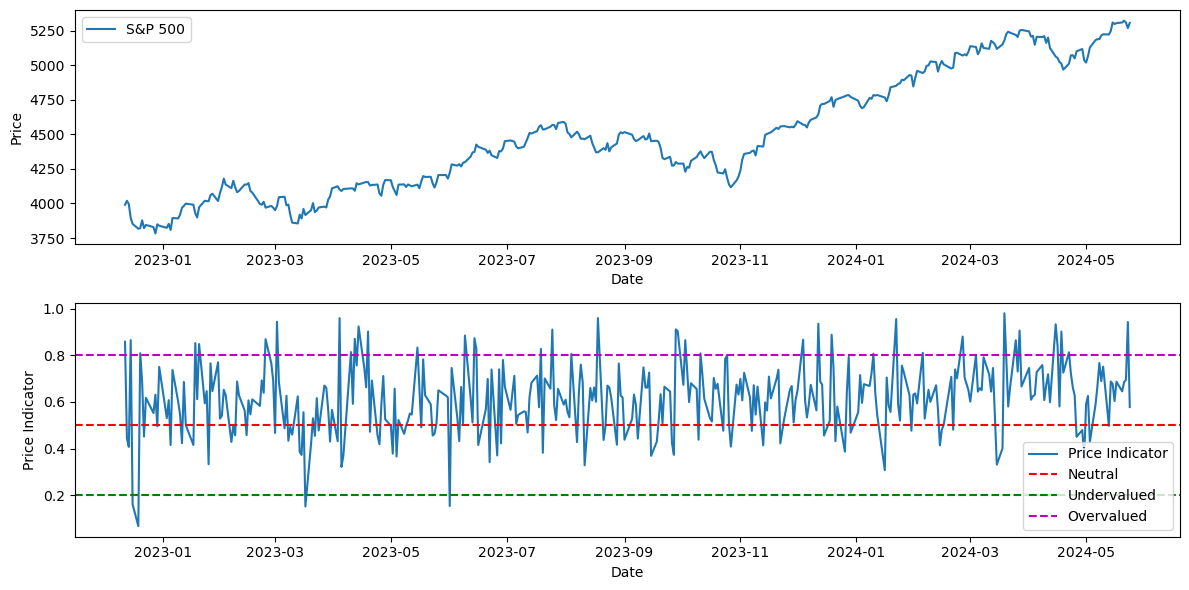

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Step 1. Download S&P 500 index data from Yahoo Finance
# ===========================================================
spx = yf.Ticker('^GSPC')
spx_data = spx.history(period='max')

# Step 2. Add a Selection of Indicators that you would like to incorporate in the model
# ===========================================================

# Create momentum indicators
spx_data['daily_vol'] = spx_data['Volume'].diff()
spx_data['daily_ret'] = spx_data['Close'].pct_change()
spx_data['30d_ma'] = spx_data['Close'].rolling(30).mean()
spx_data['daily_range'] = spx_data['High'] - spx_data['Low']
spx_data['30d_std'] = spx_data['Close'].rolling(30).std()

# Add MACD indicator
spx_data['macd'] = spx_data['Close'].ewm(span=12, adjust=False).mean() - spx_data['Close'].ewm(span=26, adjust=False).mean()

# smoothed MACD line
spx_data['signal'] = spx_data['macd'].ewm(span=9, adjust=False).mean()

# Step 3. Split the Data for Training and Out-of-Sample Testing
# ===========================================================

# Split data and create KNN model
train = spx_data.iloc[:-365, :]
test = spx_data.iloc[-365:, :]

# Handle missing values in the training data
imputer = SimpleImputer(strategy='mean')
X_train = train[['daily_vol', 'daily_ret', '30d_ma', 'daily_range', '30d_std', 'macd', 'signal']]
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
y_train = train['Close']

X_test = test[['daily_vol', 'daily_ret', '30d_ma', 'daily_range', '30d_std', 'macd', 'signal']]
y_test = test['Close']

# Step 4. Check for Corrlation between Features and Remove Features that are too Similar and Highly Correlated
# ===========================================================
# Check correlation between features
corr = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 5. Run the Kth Nearest Neighbours (KNN) Model
# ===========================================================

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 6. Create price indicator
# ===========================================================
y_pred = knn.predict(X_test)
test.loc[:, 'price_indicator'] = (y_test - y_pred) / y_test

# Step 7. Plot price and indicator
# ===========================================================
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(test.index, test['Close'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test.index, test['price_indicator'], label='Price Indicator')
plt.axhline(y=0.5, color='r', linestyle='--', label='Neutral')
plt.axhline(y=0.2, color='g', linestyle='--', label='Undervalued')
plt.axhline(y=0.8, color='m', linestyle='--', label='Overvalued')
plt.xlabel('Date')
plt.ylabel('Price Indicator')
plt.legend()

plt.tight_layout()
plt.show()